**Goal**: Explore data and be able to identify outlier sales based on past sales
    
**Assumption**: I assume that I can look at the data overall to identify a strategy. Eg: importance of StoreType, seasonnality, etc. Ideally, when asked to build such an outlier detector, we'll use past data to infer a strategy, and build a product for the future days.

**High level detection system**: 
 - we need to remove seasonnality (long term (at the year scale), and short term (at the week scale))
 - once that's removed, it is easy to detect outliers using IQR or Z test for instance, in a *big enough* distribution
 
    => if we have enough data for a given store (and potentially within the same condition of "promo"), it's simple
    
    => problems arise when we don't have enough data for a given store, we will probably have to group the stores by "similar" stores / days (same condition of promo? holidays? type? assortment?)

In [2]:
from datetime import datetime, date
import pandas as pd
import numpy as np
import random
import scipy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from statsmodels.stats.weightstats import ztest
from sklearn.ensemble import RandomForestClassifier

%load_ext autoreload
%autoreload 2
%matplotlib inline  

We load the sales data, and take a brief look at the data

In [3]:
sales_df = pd.read_csv(open('all/train.csv', 'rb'))

//anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
sales_df.head().append(sales_df.tail())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [5]:
sales_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000
mean,558.429727,3.998341,5773.818972,633.145946,0.830107,0.381515,0.178647
std,321.908651,1.997391,3849.926175,464.411734,0.375539,0.485759,0.383056
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,3727.000000,405.000000,1.000000,0.000000,0.000000
50%,558.000000,4.000000,5744.000000,609.000000,1.000000,0.000000,0.000000
75%,838.000000,6.000000,7856.000000,837.000000,1.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000,1.000000


In [6]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 77.6+ MB


No missing data - yihaa

We make some more feature that will make the exploratory analysis easier

In [7]:
# I always prefer to have a clean index - and multiindexes (like here (Date, Store) are not fun to work with in pandas)
sales_df.index = range(len(sales_df))
# processing the dates for potential further usage
sales_df['Date'] = sales_df['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
sales_df['Year'] = sales_df['Date'].apply(lambda x: x.year)
sales_df['Month'] = sales_df['Date'].apply(lambda x: x.month)
sales_df['Day'] = sales_df['Date'].apply(lambda x: x.day)
sales_df['WeekOfYear'] = sales_df['Date'].apply(lambda x: x.isocalendar()[1])
# adding sales per customers (we can study outliers on this variable if we have time - which we won't :)
sales_df['SalePerCustomer'] = sales_df['Sales']/sales_df['Customers']
# to simplify, I'll encode the holiday as a boolean
sales_df['StateHoliday'] = sales_df['StateHoliday'].apply(lambda x: str(x) != "0")
# we exclude the non opened days
sales_df = sales_df[sales_df['Open'] == 1]


We load the stores data, and take a brief look at the data

In [8]:
stores_df = pd.read_csv(open('all/store.csv', 'rb'))

In [9]:
stores_df.head().append(stores_df.tail())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,NaN,NaN,NaN
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620,9,2009,0,NaN,NaN,NaN
4,5,a,a,29910,4,2015,0,NaN,NaN,NaN
1110,1111,a,a,1900,6,2014,1,31,2013,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880,4,2006,0,NaN,NaN,NaN
1112,1113,a,c,9260,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350,NaN,NaN,1,22,2012,"Mar,Jun,Sept,Dec"


In [10]:
stores_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [11]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 95.8+ KB


Let's take a closer look at the missing data for Promo2 data

In [12]:
len(stores_df['Promo2']) == len(stores_df['Promo2'].dropna())

True

We don't have any missing data when a 'Promo2' is in action. Same for 'Competition'

Let's now merge the 2 dataframes, and featurise 'Promo2' and 'Competition' so it's actionnable

In [13]:
data_df = pd.merge(sales_df, stores_df, left_on = 'Store', right_on = 'Store')
stores_df.set_index('Store', inplace = True)

In [14]:
data_df['CompetitionOpenSinceYear'] = data_df['CompetitionOpenSinceYear'].astype(float)
data_df['CompetitionOpenSinceMonth'] = data_df['CompetitionOpenSinceMonth'].astype(float)

In [15]:
def is_promo2_running(x):
    promo_interval_dict = {
        'Jan': 1,
        'Feb': 2,
        'Mar': 3,
        'Apr': 4,
        'May': 5,
        'Jun': 6,
        'Jul': 7,
        'Aug': 8,
        'Sept': 9,
        'Oct': 10,
        'Nov': 11,
        'Dec': 12
    }
    if x['Promo2'] == 0:
        return False
    if x['Year'] == int(x['Promo2SinceYear']):
        if x['WeekOfYear'] >= int(x['Promo2SinceWeek']):
            return x['Month'] in [promo_interval_dict[k] for k in x['PromoInterval'].split(',')]
        else:
            return False
    elif x['Year'] > int(x['Promo2SinceYear']):
        return x['Month'] in [promo_interval_dict[k] for k in x['PromoInterval'].split(',')]
    else:
        return False
    
def is_competition_running(x):
    if pd.isnull(x['CompetitionOpenSinceYear']):
        return False
    return (x['Year'] > x['CompetitionOpenSinceYear']) | ((x['Year'] == x['CompetitionOpenSinceYear']) & (x['Month'] >= x['CompetitionOpenSinceMonth'] ))
    
data_df['Promo2Running'] = data_df.apply(lambda x: is_promo2_running(x), axis = 1)
data_df['CompetitionRunning'] = data_df.apply(lambda x: is_competition_running(x), axis = 1)
del data_df['Promo2']
del data_df['Promo2SinceWeek']
del data_df['Promo2SinceYear']
del data_df['PromoInterval']
del data_df['CompetitionOpenSinceYear']
del data_df['CompetitionOpenSinceMonth']

Now, we featurized everything we may need.

Let's take a look at these sales a bit more in depth, and the dependency on the various variables.

**StoreType:**

In [16]:
data_df.groupby('StoreType')['Sales'].describe()

StoreType       
a          count    457077.000000
           mean       6925.167661
           std        3277.786381
           min           0.000000
           25%        4695.000000
           50%        6285.000000
           75%        8406.000000
           max       41551.000000
b          count     15563.000000
           mean      10231.407505
           std        5157.190155
           min           0.000000
           25%        6344.000000
           50%        9130.000000
           75%       13183.500000
           max       38722.000000
c          count    112978.000000
           mean       6932.512755
           std        2897.564578
           min           0.000000
           25%        4915.000000
           50%        6407.000000
           75%        8349.000000
           max       31448.000000
d          count    258774.000000
           mean       6822.141881
           std        2556.582881
           min           0.000000
           25%        5050.0000

That's not super visual... A graph is worth 1000 words...

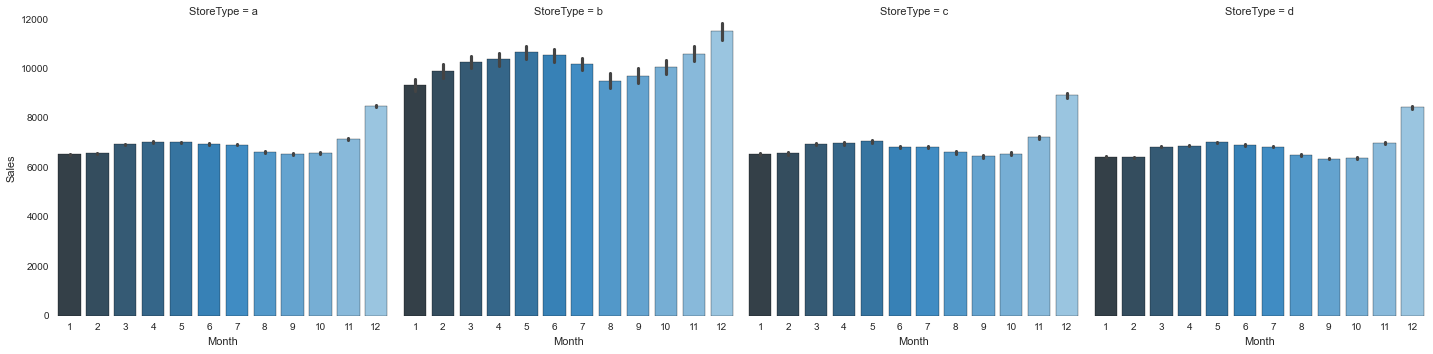

In [17]:
sns.factorplot(data = data_df, 
               x = 'Month', 
               y = 'Sales', 
               col = 'StoreType',
               palette='Blues_d')

There is a strong seasonnality, that seems to be the same for all stores except type B.

Let's discount the monthly seasonality to smoothen the effects. This will enable us not to worry about discriminating on the month. We will distinguish `B store type seasonnality` and `other store type seasonnality`

To do so, we'll ajust the Sales on a given shop and day, by the ratio (average volume of month for type) / (average volume across months for type). 

This is very basic, and we could use a much more sophisticated approach (decomposing trend + seasonnal + residual), but we'll stop there.

In [18]:
monthly_type_mean_dict = data_df.groupby(['StoreType', 'Month']).mean()['Sales'].to_dict()
type_mean_dict = data_df.groupby(['StoreType']).mean()['Sales'].to_dict()
monthly_type_ajustment_dict = {k: v/type_mean_dict[k[0]] for k, v in monthly_type_mean_dict.items()}
data_df['Yearly_seasonnality_adjusted_sales'] = data_df.apply(lambda x: x['Sales'] / monthly_type_ajustment_dict[(x['StoreType'], x['Month'])], axis = 1)

In [19]:
data_df.groupby(['StoreType', 'Assortment'])['Sales'].describe()

StoreType  Assortment       
a          a           count    286053.000000
                       mean       6537.617613
                       std        3055.933080
                       min           0.000000
                       25%        4452.000000
                       50%        5956.000000
                       75%        7950.000000
                       max       38025.000000
           c           count    171024.000000
                       mean       7573.379923
                       std        3524.599936
                       min           0.000000
                       25%        5183.000000
                       50%        6874.000000
                       75%        9128.000000
...
d          a           mean       6433.619038
                       std        2380.413109
                       min           0.000000
                       25%        4751.000000
                       50%        6063.000000
                       75%        7738.000000
 

Let's take a look at the seasonnality by week

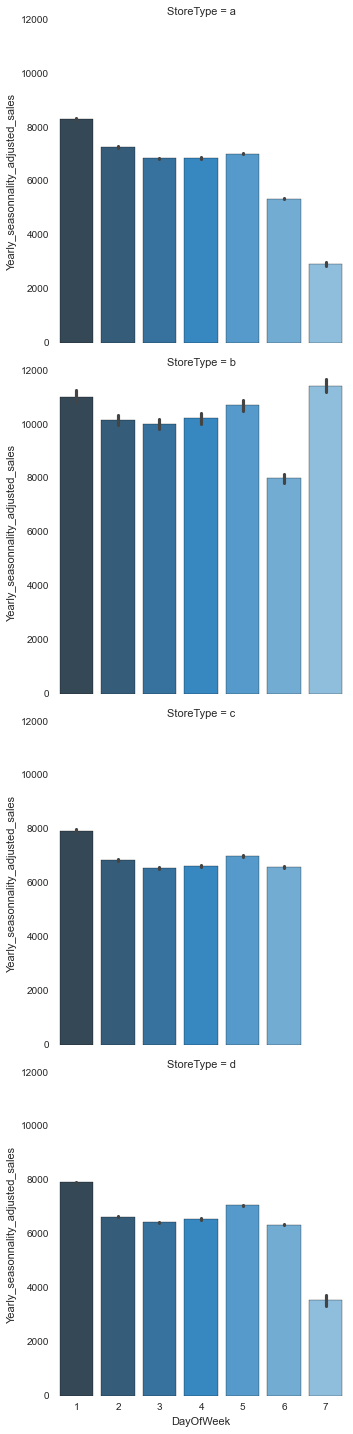

In [20]:
sns.factorplot(data = data_df, 
               x = 'DayOfWeek', 
               y = 'Yearly_seasonnality_adjusted_sales', 
               row = 'StoreType',
               palette='Blues_d')

Store C are always closed on Sunday. We could group A, C and D together, while C should be handled separately (at least for the Sunday). It is as easy to just split by StoreType, so be it.

We apply a similar method as for the monthly approach.

In [21]:
weekly_type_mean_dict = data_df.groupby(['StoreType', 'DayOfWeek']).mean()['Yearly_seasonnality_adjusted_sales'].to_dict()
type_mean_dict = data_df.groupby(['StoreType']).mean()['Yearly_seasonnality_adjusted_sales'].to_dict()
weekly_type_ajustment_dict = {k: v/type_mean_dict[k[0]] for k, v in weekly_type_mean_dict.items()}
data_df['Seasonnality_adjusted_sales'] = data_df.apply(lambda x: x['Yearly_seasonnality_adjusted_sales'] / weekly_type_ajustment_dict[(x['StoreType'], x['DayOfWeek'])], axis = 1)

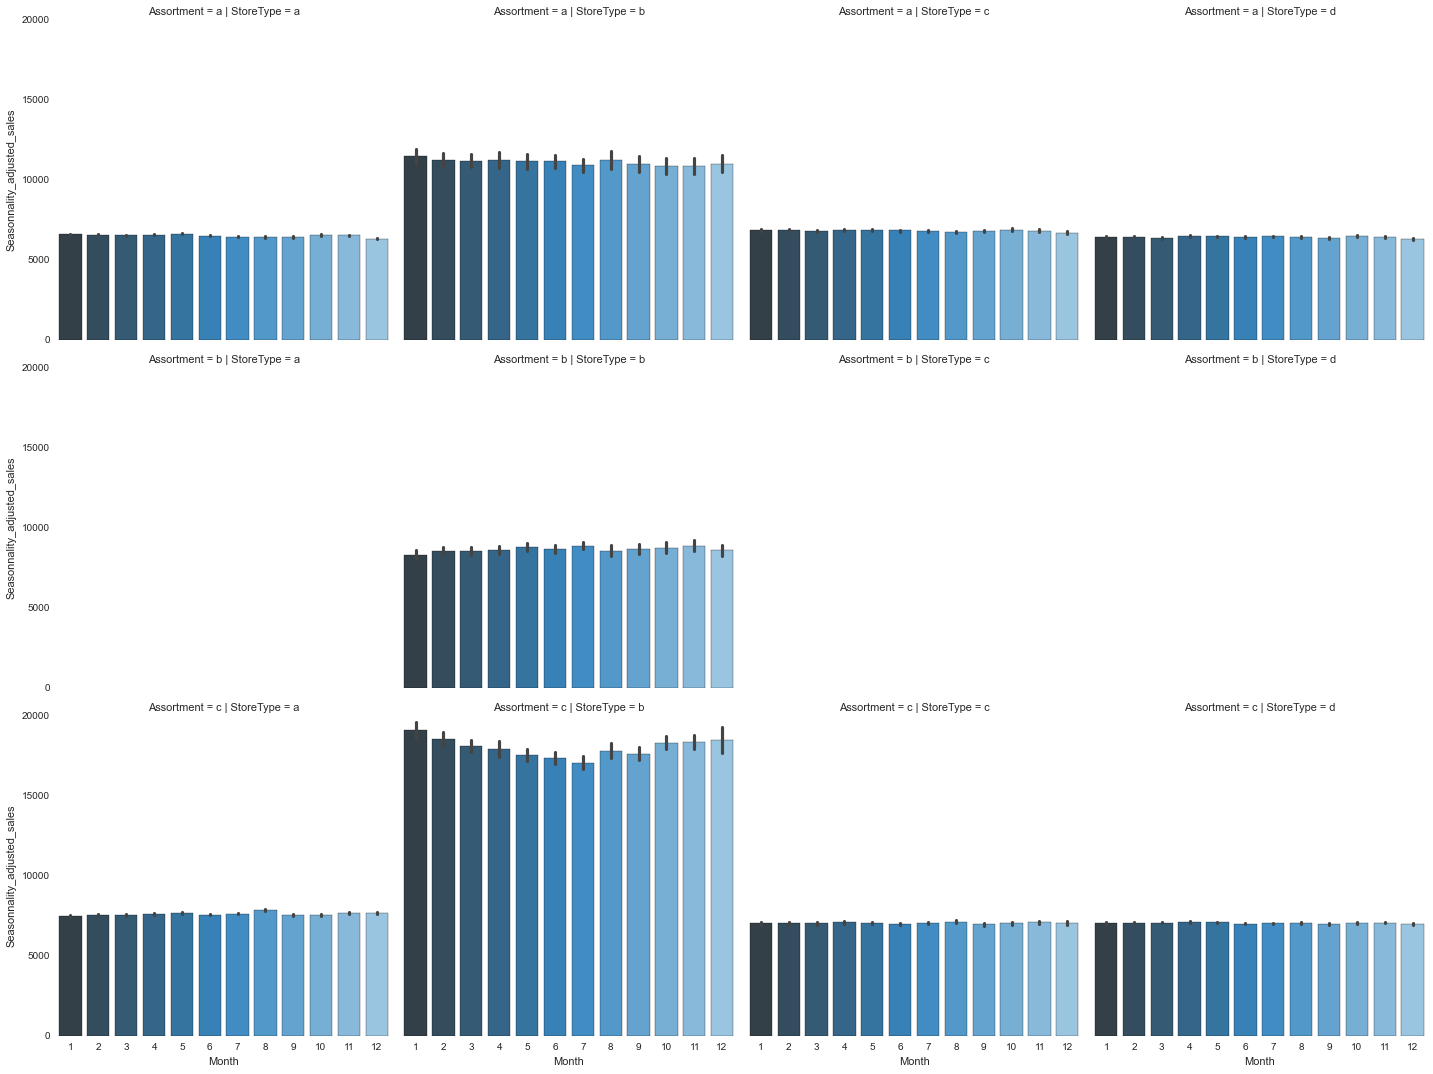

In [22]:
sns.factorplot(data = data_df, 
               x = 'Month', 
               y = 'Seasonnality_adjusted_sales', 
               col = 'StoreType',
               row = 'Assortment',
               palette='Blues_d')

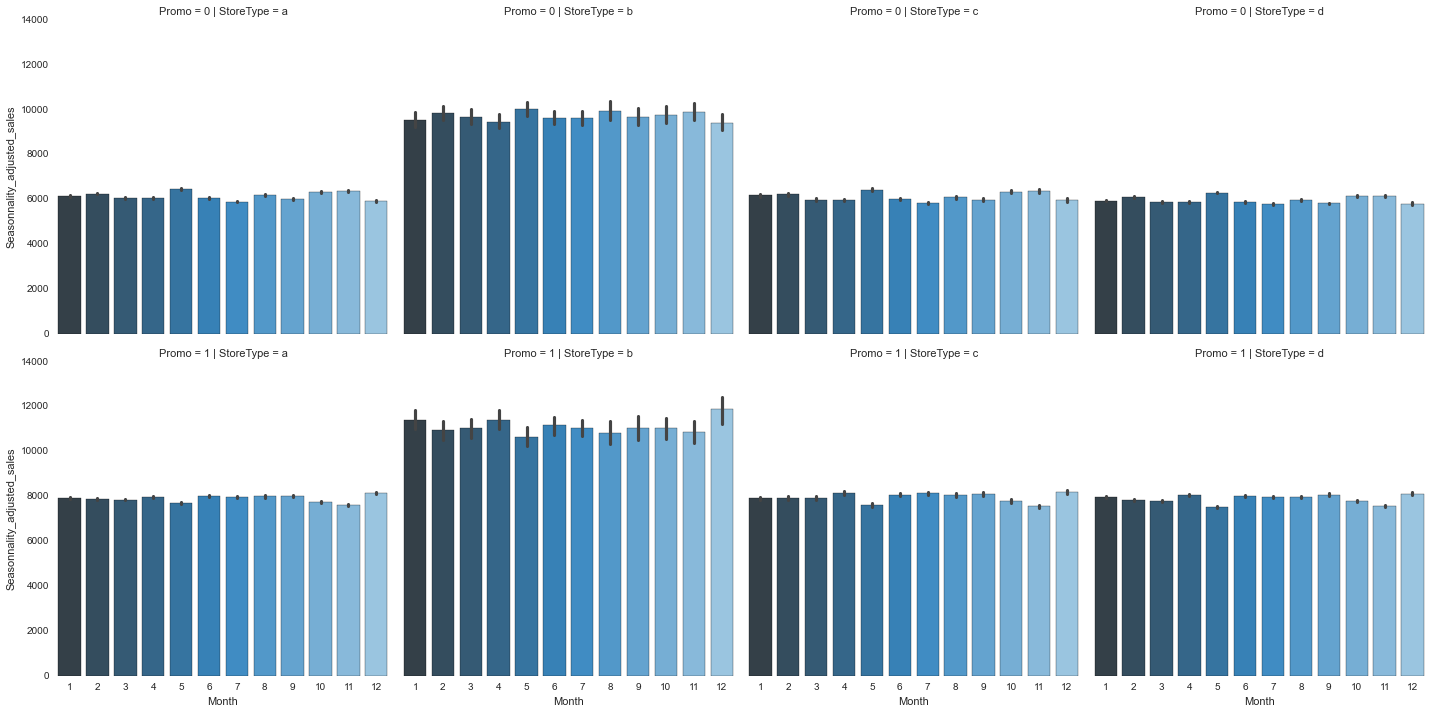

In [23]:
sns.factorplot(data = data_df, 
               x = 'Month', 
               y = 'Seasonnality_adjusted_sales', 
               col = 'StoreType',
               row = 'Promo',
               palette='Blues_d')

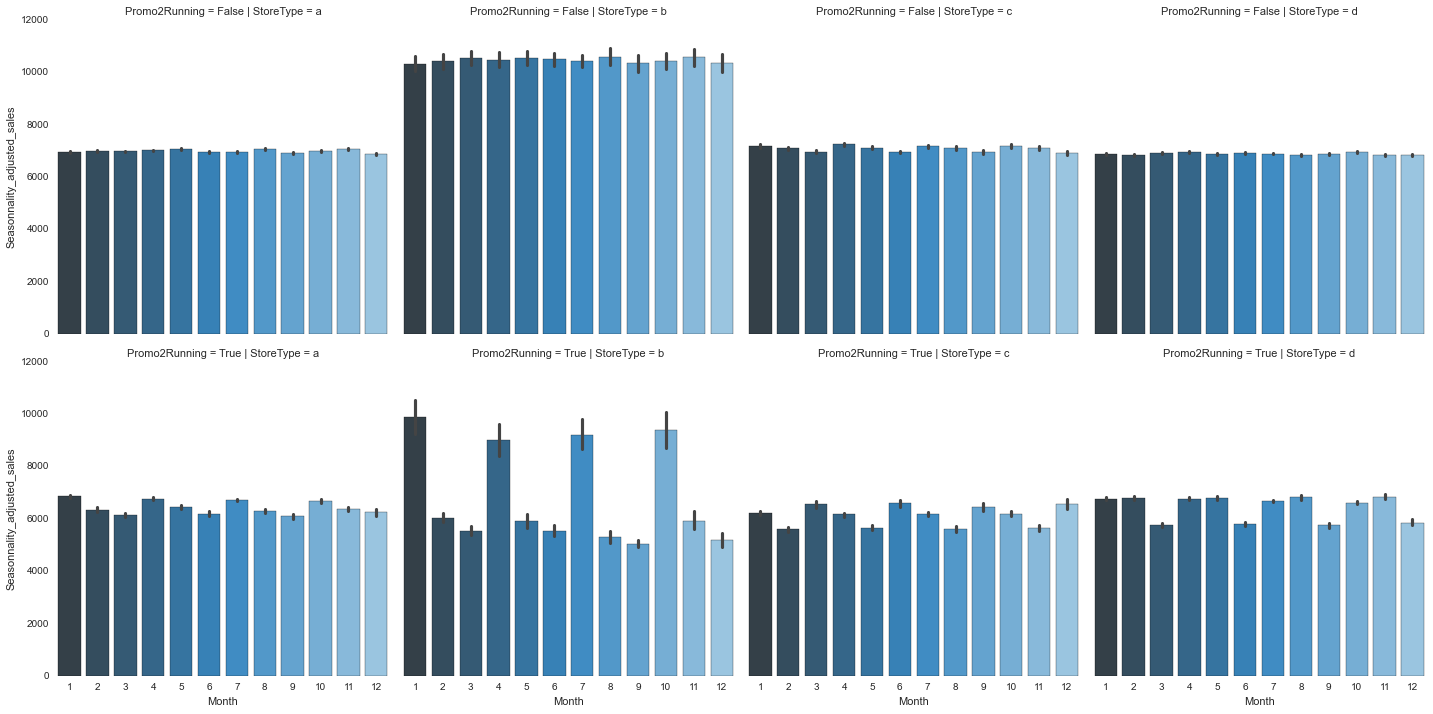

In [24]:
sns.factorplot(data = data_df, 
               x = 'Month', 
               y = 'Seasonnality_adjusted_sales', 
               col = 'StoreType',
               row = 'Promo2Running',
               palette='Blues_d')

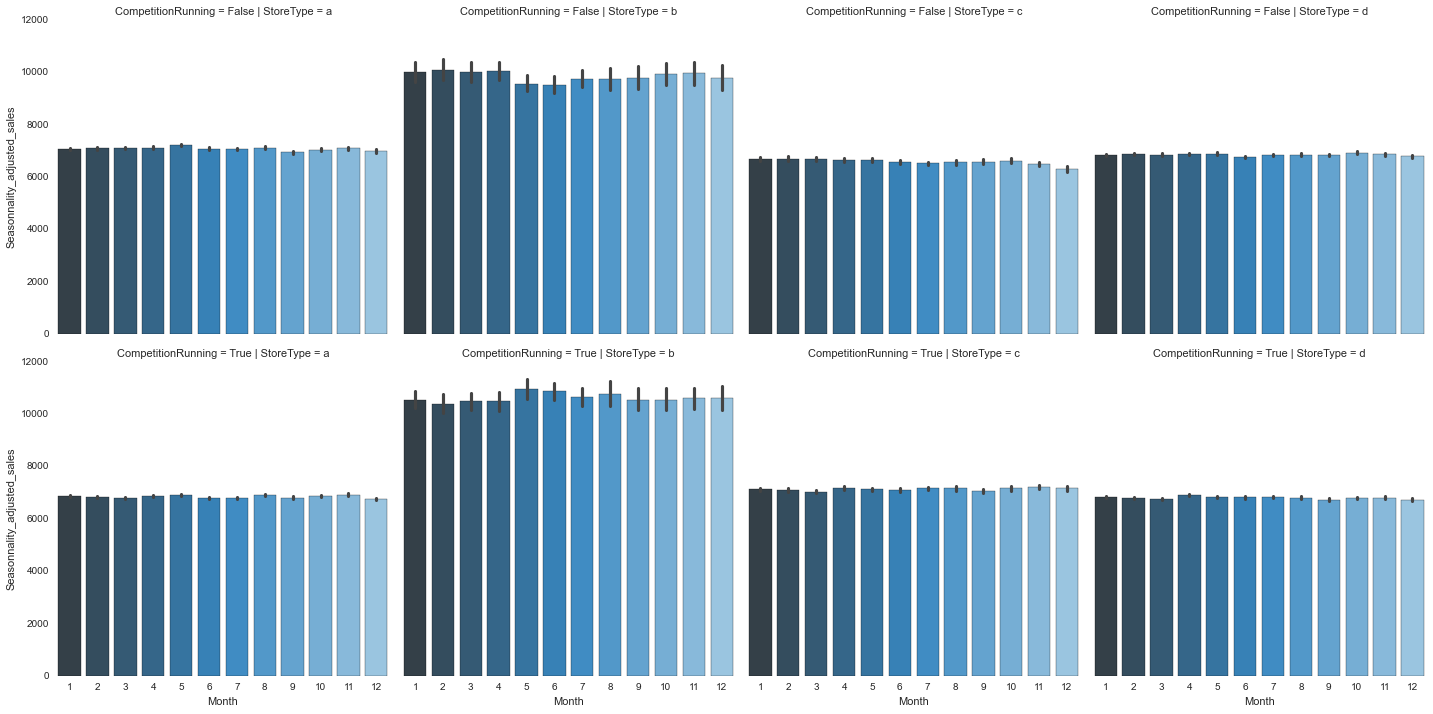

In [25]:
sns.factorplot(data = data_df, 
               x = 'Month', 
               y = 'Seasonnality_adjusted_sales', 
               col = 'StoreType',
               row = 'CompetitionRunning',
               palette='Blues_d')

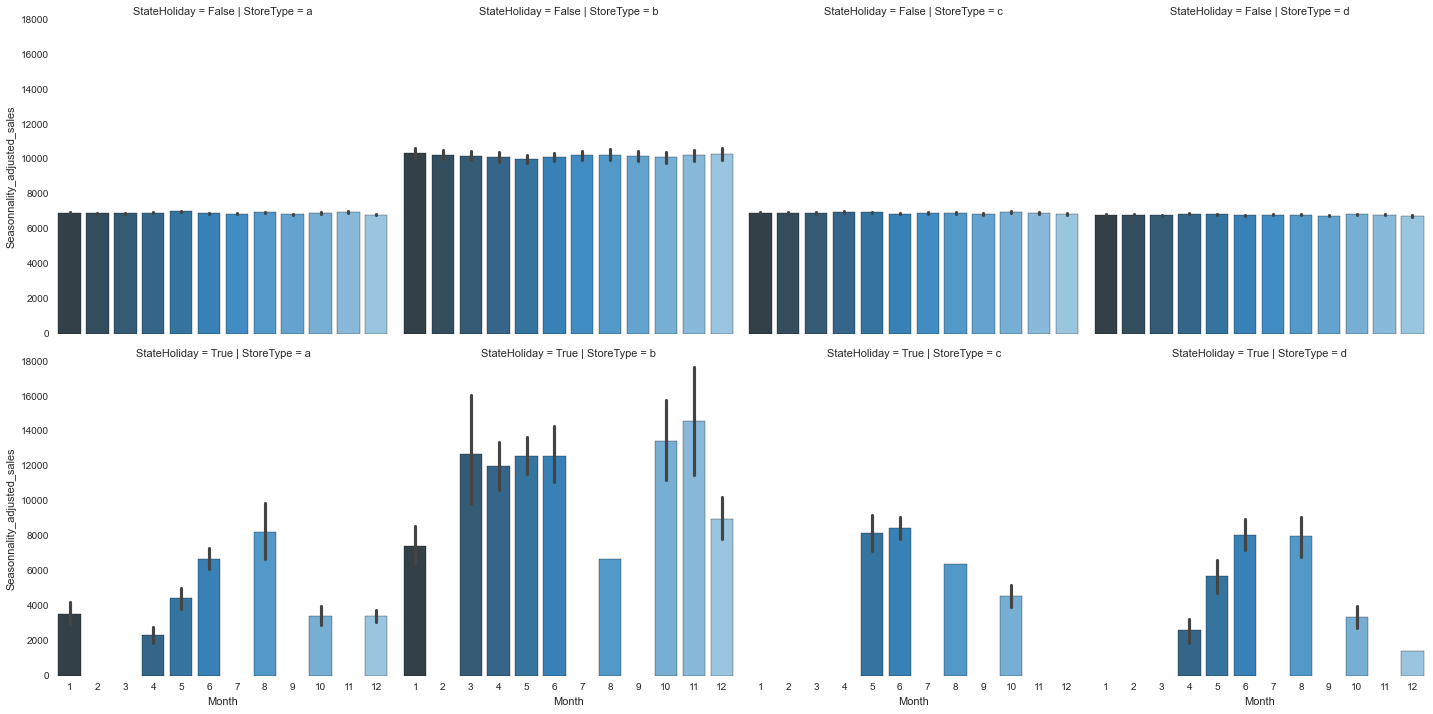

In [26]:
sns.factorplot(data = data_df, 
               x = 'Month', 
               y = 'Seasonnality_adjusted_sales', 
               col = 'StoreType',
               row = 'StateHoliday',
               palette='Blues_d')

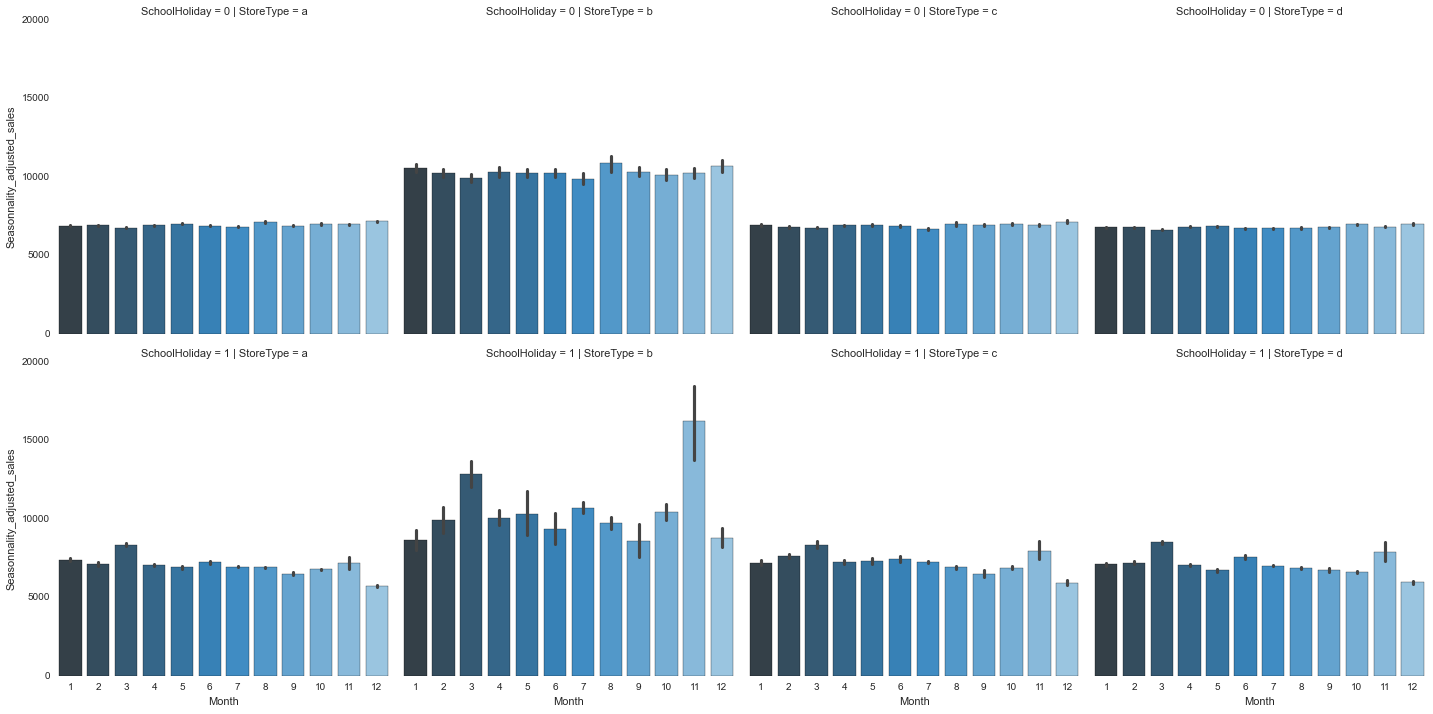

In [27]:
sns.factorplot(data = data_df, 
               x = 'Month', 
               y = 'Seasonnality_adjusted_sales', 
               col = 'StoreType',
               row = 'SchoolHoliday',
               palette='Blues_d')

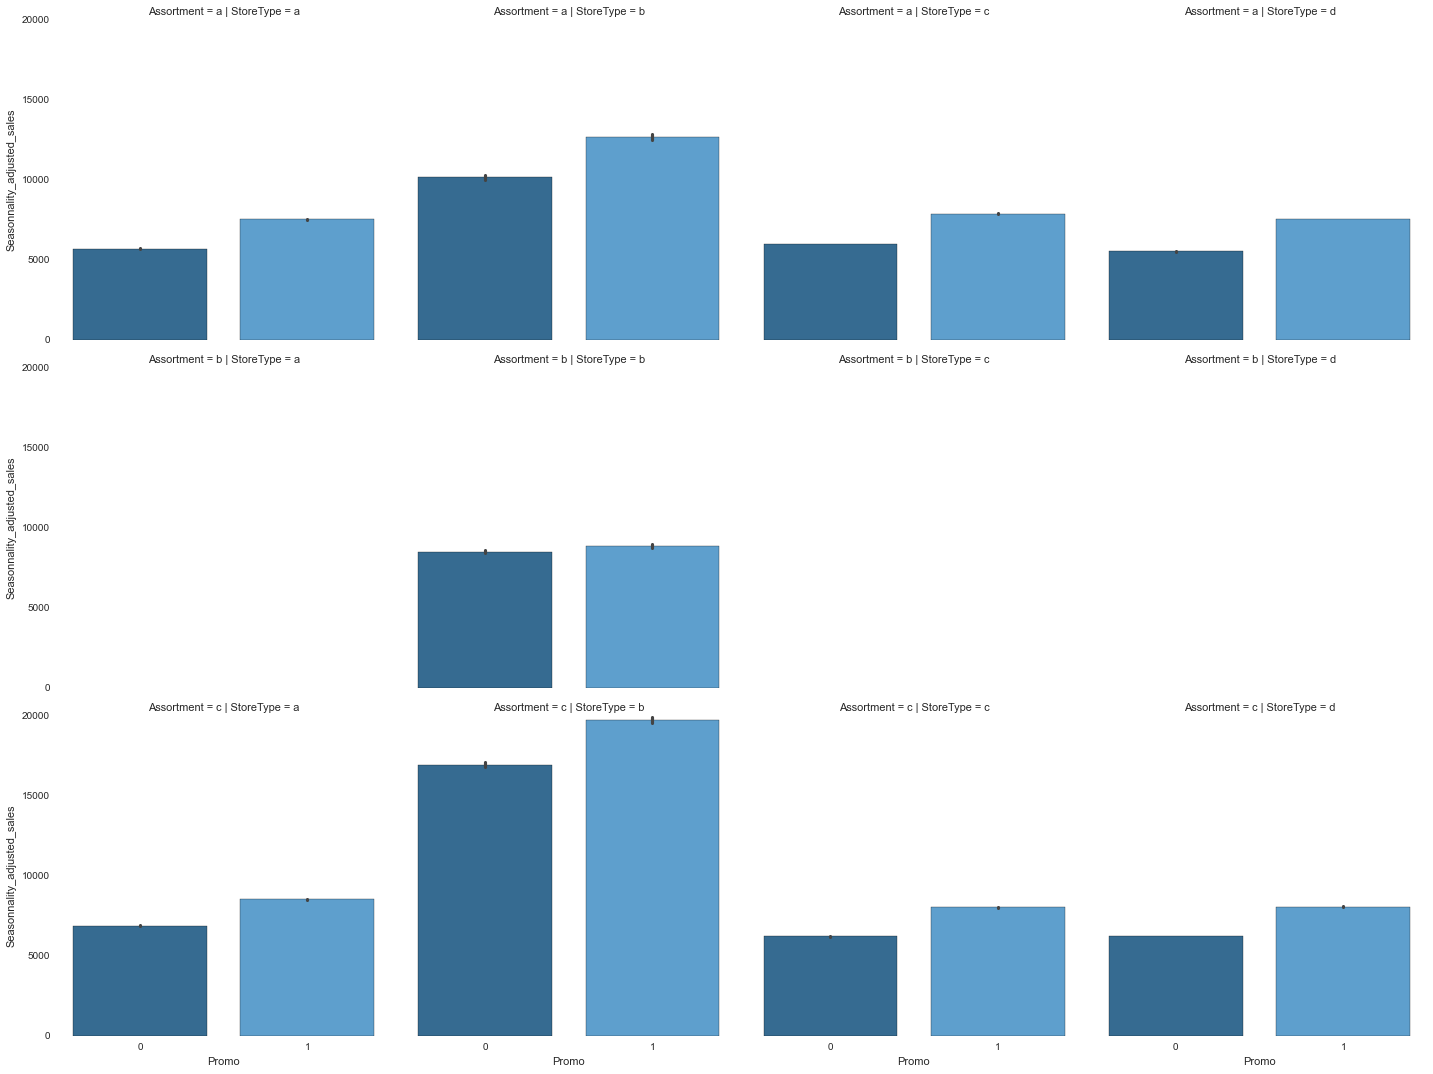

In [28]:
sns.factorplot(data = data_df, 
               x = 'Promo', 
               y = 'Seasonnality_adjusted_sales', 
               col = 'StoreType',
               row = 'Assortment',
               palette='Blues_d')

We can infer what variables contribute to the sales #, and will help us to determine outliers:

- the store type and the assortment. Here, we can group store types (A, C, D) together, while for store type B, we should differentiate assortment A, B and C.

- the promo

By lack of time, we drop other effects...

The previous graphs also help us determine the priority:
 - find if a store is type B or the rest
 - if it's type A, C or D, finding if it has a promo
 - if it's type B, finding the assortment type
 - finally, in this case, finding if it has a promo

Let's see how we can find outliers in a distribution.

I implemented 2 methods, one using IQR and the other one using the Z-score.

In [45]:
def finding_outliers_using_iqr(df, threshold = 1.5):
    # We can use the IQR to find outliers (IQR = Q3 and Q1, with Q being quartiles)
    # an outliers will either be - standard threshold is 1.5
        # < Q1 - threshold * IQR
        # < Q3 + threshold * IQR
    q1 = np.percentile(np.array(df['Sales']), 25)
    q3 = np.percentile(np.array(df['Sales']), 75)
    iqr = q3 - q1
    condition1 = df['Sales'] < q1 - threshold * iqr
    condition2 = df['Sales'] > q3 + threshold * iqr
    outliers = df[condition1 | condition2]
    print("Outliers are below {c1} and {c2}".format(c1 = str(q1 - 1.5 * iqr), c2 = str(q3 + 1.5 * iqr)))
    return outliers


def finding_outliers_using_z_score(df, threshold = 2.5):
    # We can also use the z-score, that determines how many standard deviations a point is from the mean, 
    # assuming a gaussian distribution (this can be true for a given shop, and same day of the week for instance)
    # - typical threshold is 3 standard deviations
        # < Q1 - 1.5 IQR
        # < Q3 + 1.5 IQR
    array = df['Sales']
    df['ZScore'] = scipy.stats.mstats.zscore(array)
    condition1 = df['ZScore'] >= threshold
    condition2 = df['ZScore'] <= -threshold
    outliers = df[condition1 | condition2]
    return outliers

We now have all the necessary pieces for our algorithm, that is quite naive.

We take n = 100 to make sure we have enough instances in our distribution to find outliers.

To check if sales for a (store, date) are an outlier, we will check for outliers in seasonality adjusted sales before that date:
  - find all the sales for the same store type * assortment, same promo. 
    If the total number of observations > n, we find outliers in there
    Otherwise, we:
  - find all the sales for the same store type * assortment
    If the total number of observations > n, we find outliers in there

In [40]:
def get_my_row(store, date):
    try:
        my_row = data_df[(data_df['Store'] == store) & (data_df['Date'] == date)].iloc[0]
    except:
        if date > max(data_df['Date']) or date < min(data_df['Date']):
            raise Exception('Date out of bound')
        else:
            raise Exception('No data for this day')
    return my_row

def get_my_relevant_sample(store, date, data_df = data_df, n = 100):
    my_row = get_my_row(store, date)
    sample_df = data_df[(data_df['Date'] <= date)].copy(deep = True)
    if len(sample_df[sample_df['Store'] == store]) >= n:
        return sample_df[sample_df['Store'] == store]
    else:
        assortment = stores_df.ix[store]['Assortment']
        store_type = stores_df.ix[store]['StoreType']
        promo = my_row['Promo']
        if store_type == 'b':
            if len(sample_df[(sample_df['StoreType'] == 'b') & (sample_df['Assortment'] == assortment) & (sample_df['Promo'] == promo)]) > n:
                sample_df = sample_df[(sample_df['StoreType'] == 'b') & (sample_df['Assortment'] == assortment) & (sample_df['Promo'] == promo)]
            else:
                if len(sample_df[(sample_df['StoreType'] == 'b') & (sample_df['Assortment'] == assortment)]) > n:
                    sample_df = sample_df[(sample_df['StoreType'] == 'b') & (sample_df['Assortment'] == assortment)]
                else:
                    sample_df = sample_df[(sample_df['StoreType'] == 'b')]
        else:
            if len(sample_df[(sample_df['StoreType'].isin(['a', 'b', 'c'])) & (sample_df['Promo'] == promo)]) > n:
                sample_df = sample_df[(sample_df['StoreType'].isin(['a', 'b', 'c'])) & (sample_df['Promo'] == promo)]
            else:
                sample_df = sample_df[(sample_df['StoreType'].isin(['a', 'b', 'c']))]
    return sample_df

def is_this_date_an_outlier(store, date, data_df = data_df, n = 150, method = 'z_score', threshold = 2): 
    fct = eval('finding_outliers_using_{0}'.format(method))
    sample_df = get_my_relevant_sample(store, date, data_df, n) 
    r = fct(sample_df, threshold)
    r = r[r['Store'] == store]
    sample_df['Outlier'] = sample_df.apply(lambda x: True if x['Date'] in (list(r['Date'])) else False, axis = 1)
    sample_df['Outlier'] = sample_df['Outlier'] *  sample_df['Sales']
    sample_df.sort('Date', ascending = True, inplace = True)
    sample_df = sample_df[sample_df['Store'] == store]
    plt.figure(figsize=(35,10))
    plt.plot(range(len(sample_df)), sample_df['Sales'])
    plt.fill_between(range(len(sample_df)), [0 for k in range(len(sample_df))], sample_df['Outlier'], color = 'r')
    if date in sample_df[sample_df['Outlier'] > 0]['Date'].values:
        print('THIS DATE IS AN OUTLIER')
    if len(sample_df[sample_df['Outlier'] > 0]) > 0:
        print('The following dates are outliers: {}'.format(', '.join([str(k) for k in sample_df[sample_df['Outlier'] > 0]['Date']])))
    plt.show()
    

Let's run a bunch of examples

THIS DATE IS AN OUTLIER
The following dates are outliers: 2013-04-29


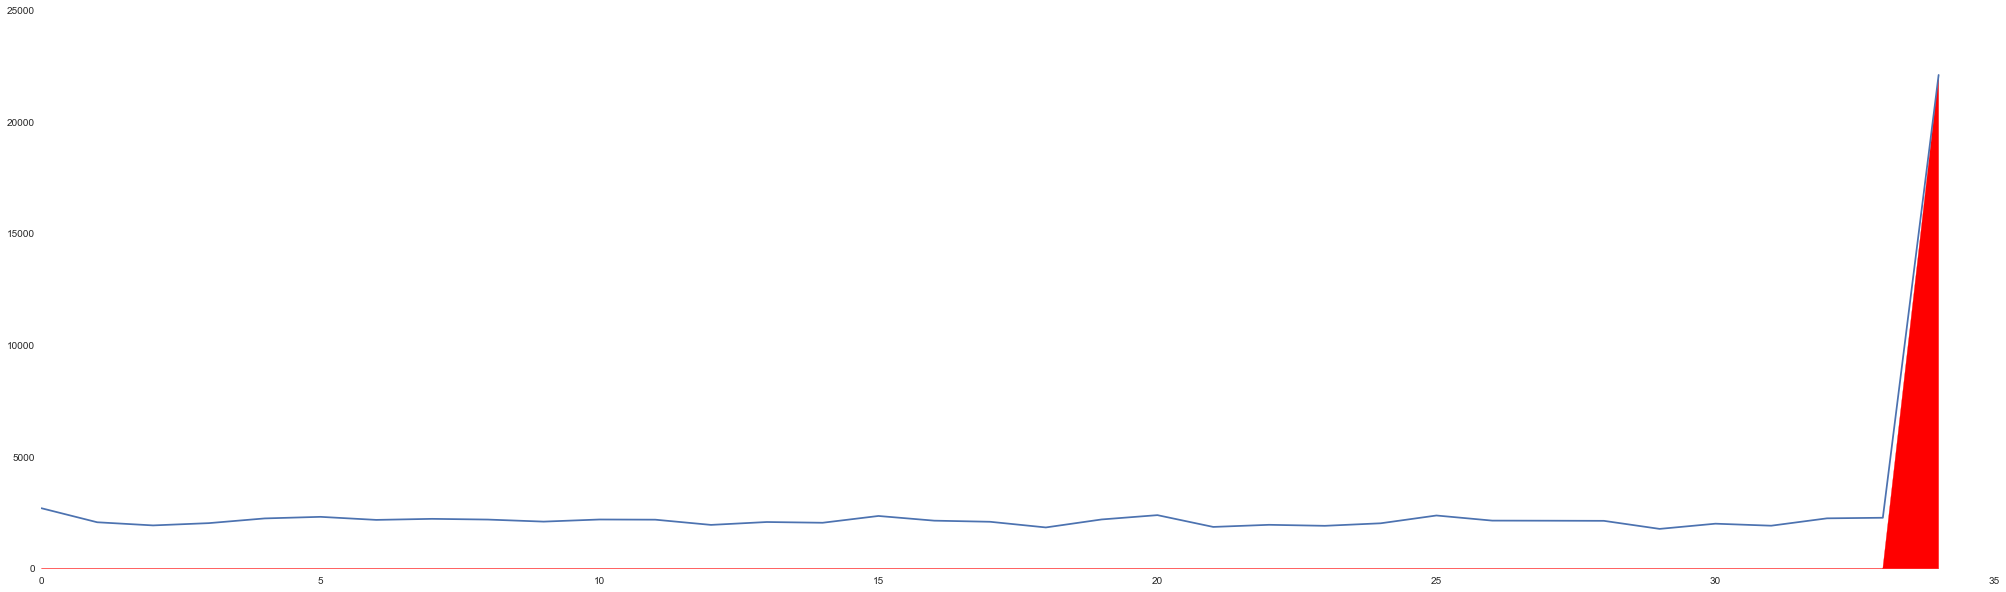

In [50]:
is_this_date_an_outlier(105, date(2013,4,29))

The following dates are outliers: 2013-04-29, 2013-04-30, 2013-05-02, 2013-05-03, 2013-12-16, 2013-12-23, 2014-01-07


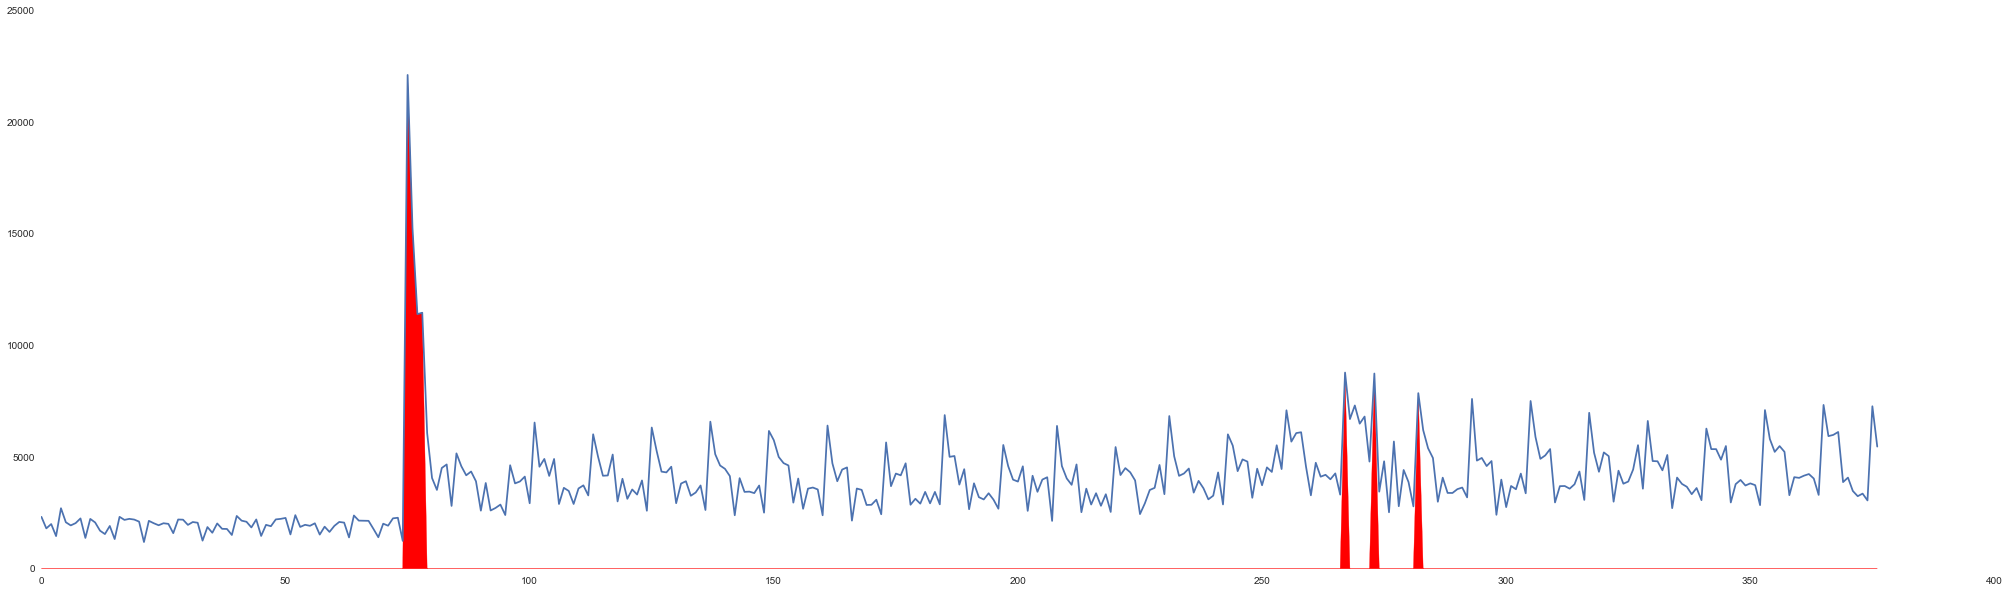

In [51]:
is_this_date_an_outlier(105, date(2014,4,29))

THIS DATE IS AN OUTLIER
The following dates are outliers: 2013-02-02


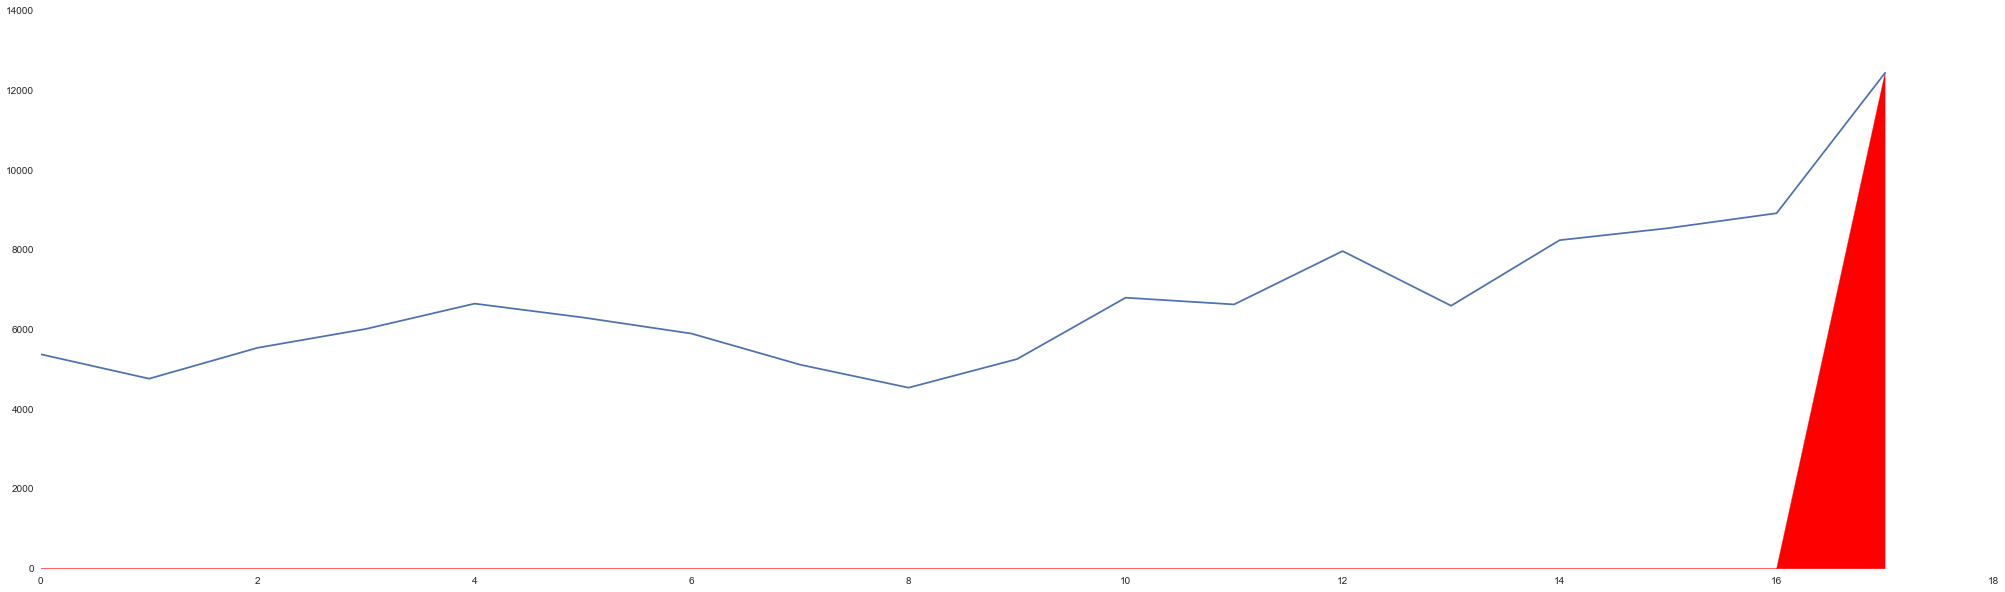

In [52]:
is_this_date_an_outlier(172, date(2013,2,2))

The following dates are outliers: 2013-02-02, 2013-02-04, 2013-02-05, 2013-02-07, 2013-02-08, 2013-02-09, 2013-02-16, 2013-02-18, 2013-02-19, 2013-02-23, 2013-03-02, 2013-03-04, 2013-03-05, 2013-03-08, 2013-03-09, 2013-03-16, 2013-03-18, 2013-03-19, 2013-03-20, 2013-12-02, 2013-12-24


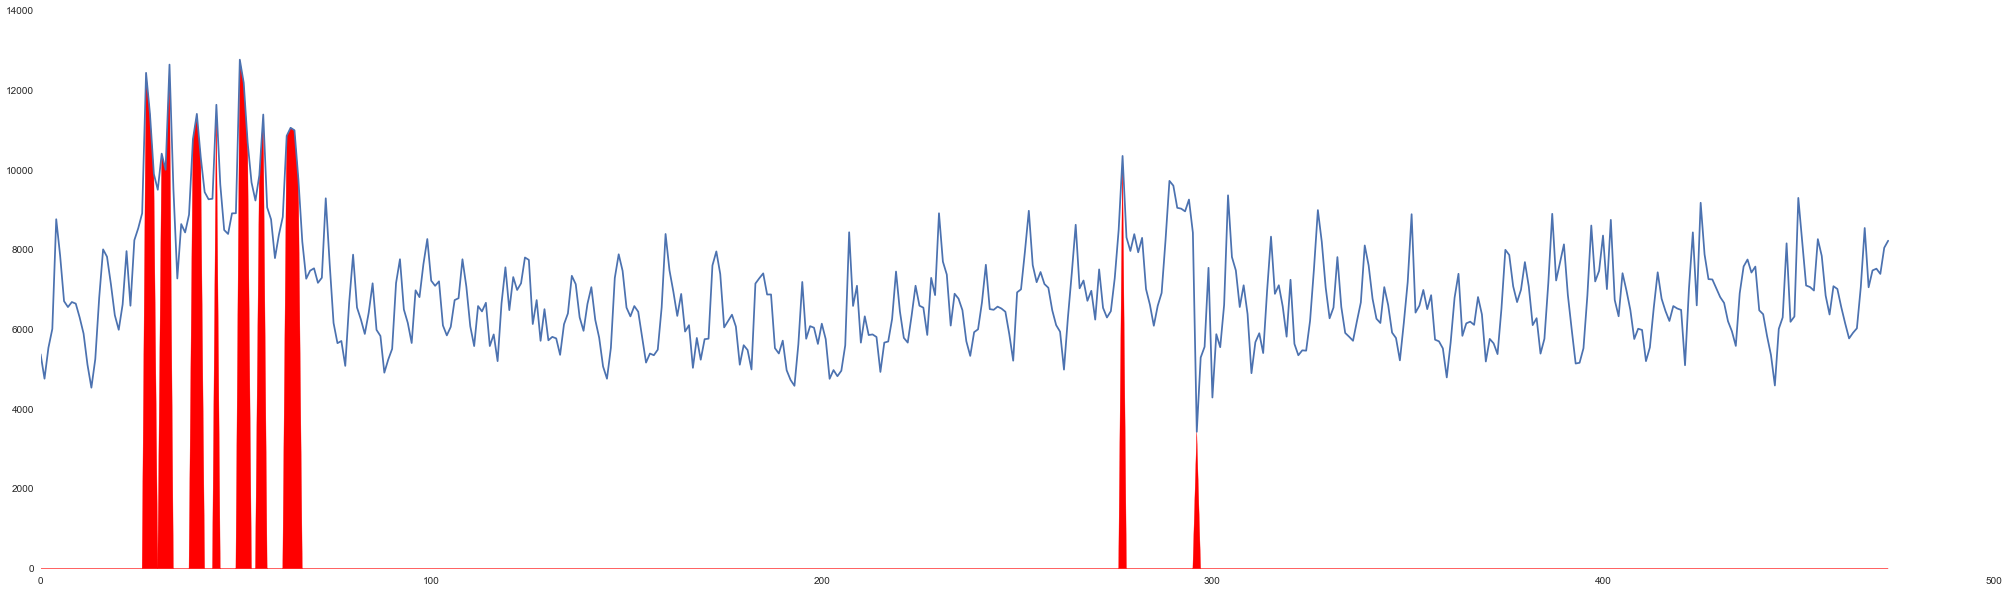

In [53]:
is_this_date_an_outlier(172, date(2015,2,2))

The following dates are outliers: 2013-04-24


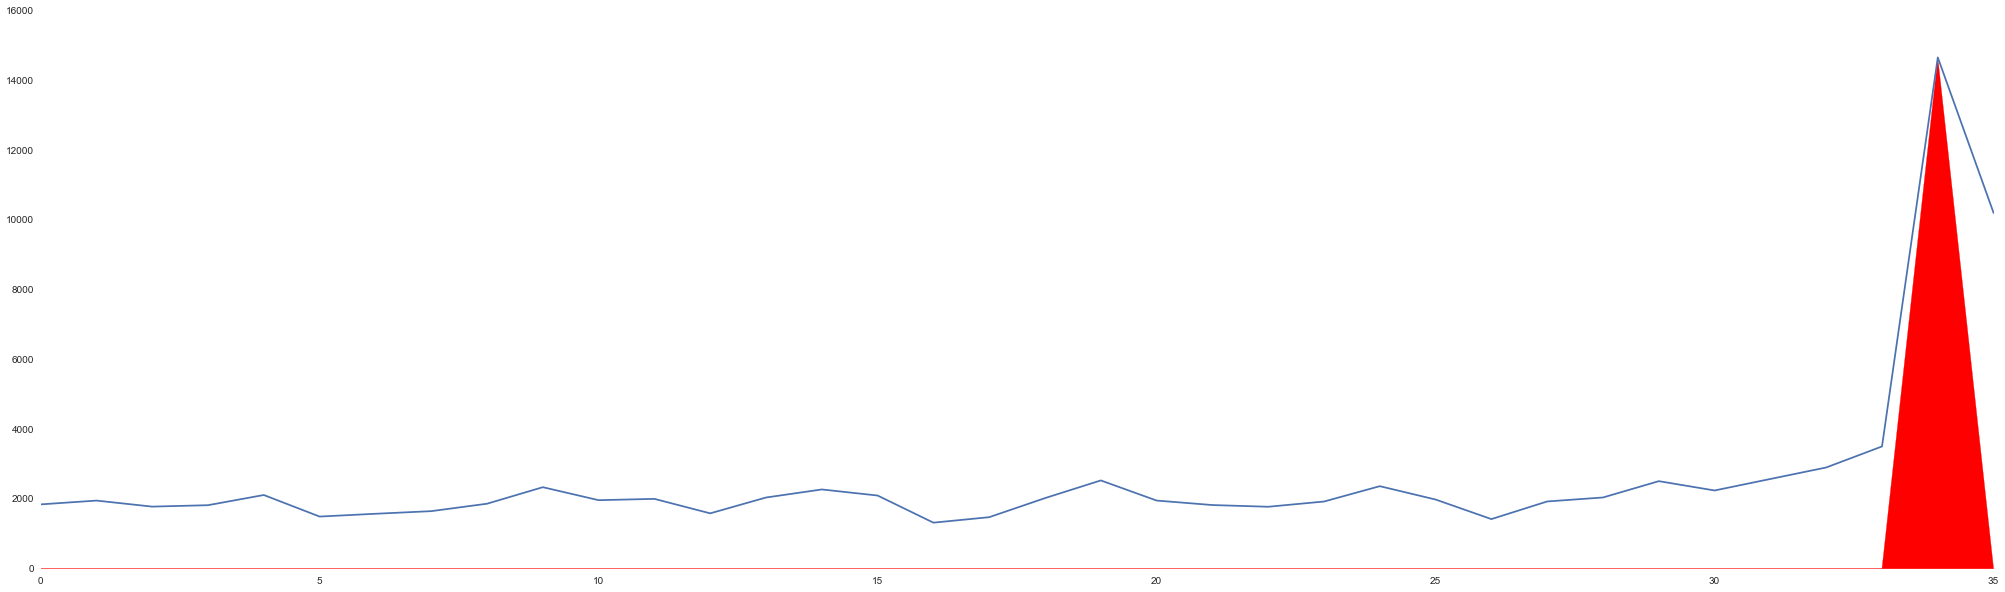

In [60]:
is_this_date_an_outlier(708, date(2013,4,25))

The following dates are outliers: 2013-04-24, 2013-04-25, 2013-12-23, 2014-06-16, 2014-06-17, 2014-06-18, 2014-06-19, 2014-06-20, 2014-06-21, 2014-10-06, 2014-10-07, 2014-10-08, 2014-10-09, 2014-10-10, 2014-12-05, 2014-12-15, 2014-12-16, 2014-12-18, 2014-12-19, 2014-12-22, 2014-12-23, 2015-03-30, 2015-03-31


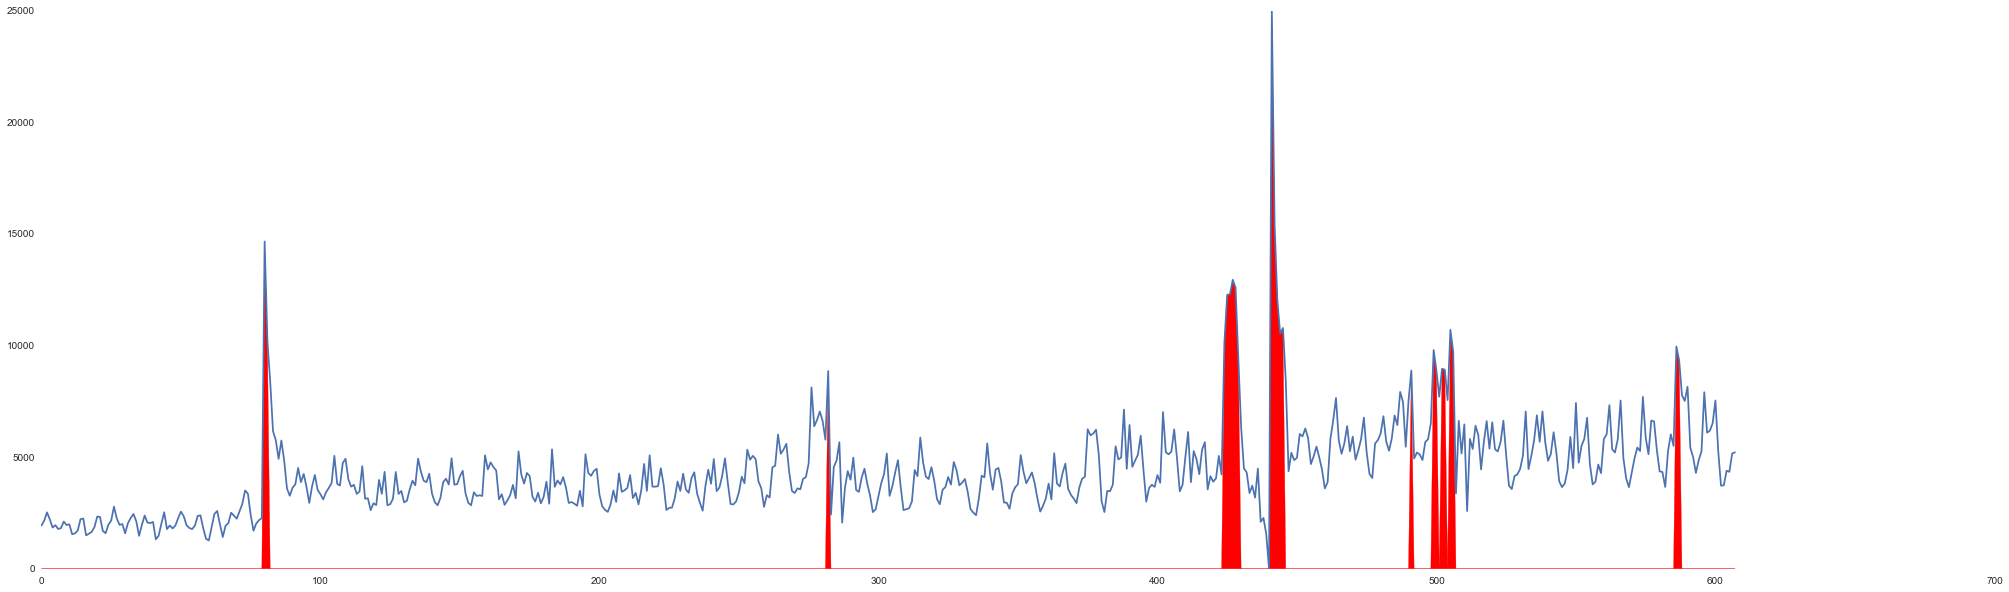

In [61]:
is_this_date_an_outlier(708, date(2015,4,25))

**Limits:**
- This is a very naive algorithm, that takes into account the volume of data.
- We would need to take into account the effects of Promo2, competition, etc.

**Other methods:**
- We could have tried to predict the sales, and then compared the distance between the actual sale and the prediction (random forest / rima / arima / etc)
- We could have used some clustering techniques
    